# YanoljaNEXT-Rosetta-4B-2510 모델 테스트
## MES 질문/프롬프트 한국어 ↔ 영어 번역 성능 평가

### 모델 특징
- JSON 구조 데이터 번역 특화
- 32개 언어 지원
- 4B 파라미터 (Gemma3 기반)

### 테스트 항목
1. **MES 용어 번역** - 단순 용어
2. **MES 질문 번역** - 사용자 질의문
3. **MES 프롬프트 번역** - 시스템 지시문
4. **성능 측정** - 속도, GPU 메모리

## 1. 환경 설정 및 라이브러리 설치

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import time
import json
from typing import List, Dict, Union, Optional
import pandas as pd
import matplotlib.pyplot as plt
import GPUtil
import psutil
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (matplotlib)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

## 2. GPU 환경 확인

In [3]:
# GPU 정보 확인
print("=" * 50)
print("GPU Information")
print("=" * 50)

if torch.cuda.is_available():
    print(f"CUDA Available: Yes")
    print(f"GPU Count: {torch.cuda.device_count()}")
    print(f"Current GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    
    gpus = GPUtil.getGPUs()
    for gpu in gpus:
        print(f"\nGPU {gpu.id}: {gpu.name}")
        print(f"  Total Memory: {gpu.memoryTotal} MB")
        print(f"  Free Memory: {gpu.memoryFree} MB")
        print(f"  Used Memory: {gpu.memoryUsed} MB")
else:
    print("CUDA Available: No (CPU mode)")

print(f"\nCPU Count: {psutil.cpu_count()}")
print(f"RAM: {psutil.virtual_memory().total / (1024**3):.2f} GB")

GPU Information
CUDA Available: Yes
GPU Count: 1
Current GPU: NVIDIA GeForce RTX 5070 Ti
CUDA Version: 12.9

GPU 0: NVIDIA GeForce RTX 5070 Ti
  Total Memory: 16303.0 MB
  Free Memory: 15244.0 MB
  Used Memory: 664.0 MB

CPU Count: 16
RAM: 31.10 GB


## 3. 모델 로드

In [4]:
# 모델 로드 시작
MODEL_NAME = "yanolja/YanoljaNEXT-Rosetta-4B-2510"

print(f"Loading model: {MODEL_NAME}")
print("This may take a few minutes...\n")

start_time = time.time()

# Tokenizer 로드
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# 모델 로드
device = "cuda" if torch.cuda.is_available() else "cpu"
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    dtype=torch.bfloat16 if device == "cuda" else torch.float32,
    device_map="auto",
    max_memory={0: "23GB"} if device == "cuda" else None,
)

load_time = time.time() - start_time

print(f"✓ Model loaded successfully in {load_time:.2f} seconds")
print(f"✓ Device: {device}")
print(f"✓ Model dtype: {model.dtype}")

if device == "cuda":
    print(f"✓ GPU Memory allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")

Loading model: yanolja/YanoljaNEXT-Rosetta-4B-2510
This may take a few minutes...



The following generation flags are not valid and may be ignored: ['cache_implementation']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Loading checkpoint shards: 100%|██████████| 3/3 [00:05<00:00,  1.91s/it]


✓ Model loaded successfully in 8.32 seconds
✓ Device: cuda
✓ Model dtype: torch.bfloat16
✓ GPU Memory allocated: 7.23 GB


## 4. MES 테스트 데이터 준비

In [6]:
# MES 테스트 데이터
# source: 번역할 JSON 데이터
# context: 번역 옵션 (context, tone, glossary 등)

test_data = [
    # ============================================
    # 1. MES 용어 번역 (한국어 -> 영어)
    # ============================================
    {
        "category": "term",
        "target_language": "English",
        "context": {
            "context": "MES terminology translation",
            "tone": "Professional and technical"
        },
        "source": {
            "work_order": "작업 지시서",
            "production_plan": "생산 계획",
            "quality_inspection": "품질 검사"
        },
        "reference": {
            "work_order": "Work Order",
            "production_plan": "Production Plan",
            "quality_inspection": "Quality Inspection"
        }
    },
    
    # ============================================
    # 2. MES 사용자 질문 (한국어 -> 영어)
    # ============================================
    {
        "category": "simple question",
        "target_language": "English",
        "context": {
            "context": "User asking about production line status",
            "tone": "Natural and conversational"
        },
        "source": {
            "question": "오늘 생산 라인의 가동률이 어떻게 되나요?"
        },
        "reference": {
            "question": "What is today's production line utilization rate?"
        }
    },
    {
        "category": "simple question",
        "target_language": "English",
        "context": {
            "context": "User asking about quality defects",
            "tone": "Natural and conversational"
        },
        "source": {
            "question": "어제 발생한 품질 불량 건수를 알려주세요."
        },
        "reference": {
            "question": "Please tell me the number of quality defects that occurred yesterday."
        }
    },
    {
        "category": "simple question",
        "target_language": "English",
        "context": {
            "context": "User asking about production achievement",
            "tone": "Natural and conversational"
        },
        "source": {
            "question": "이번 주 생산 목표 대비 달성률이 몇 퍼센트인가요?"
        },
        "reference": {
            "question": "What is the percentage of achievement against this week's production target?"
        }
    },
    
    # ============================================
    # 3. MES 복잡한 질문 (한국어 -> 영어)
    # ============================================
    {
        "category": "complicated question",
        "target_language": "English",
        "context": {
            "context": "Complex analysis request with multiple metrics",
            "tone": "Technical and analytical"
        },
        "source": {
            "request": "2라인의 어제 생산량과 불량률을 비교해서 보여주고, 전주 대비 개선율을 계산해줘."
        },
        "reference": {
            "request": "Show me a comparison of yesterday's production volume and defect rate for Line 2, and calculate the improvement rate compared to last week."
        }
    },
    {
        "category": "complicated question",
        "target_language": "English",
        "context": {
            "context": "Predictive maintenance analysis request",
            "tone": "Technical and analytical"
        },
        "source": {
            "request": "지난 3개월간 설비별 고장 빈도를 분석하고, 예방 정비가 필요한 설비 목록을 추천해줘."
        },
        "reference": {
            "request": "Analyze the failure frequency by equipment over the past 3 months and recommend a list of equipment that needs preventive maintenance."
        }
    },
    
    # ============================================
    # 4. MES 시스템 프롬프트 (한국어 -> 영어)
    # ============================================
    {
        "category": "system prompt",
        "target_language": "English",
        "context": {
            "context": "AI assistant role definition for MES",
            "tone": "Professional and instructional"
        },
        "source": {
            "system_instruction": "당신은 제조 실행 시스템(MES) 전문 AI 어시스턴트입니다. 생산 관리, 품질 관리, 설비 관리에 대한 질문에 답변해주세요."
        },
        "reference": {
            "system_instruction": "You are a Manufacturing Execution System (MES) expert AI assistant. Please answer questions about production management, quality management, and equipment management."
        }
    },
    {
        "category": "system prompt",
        "target_language": "English",
        "context": {
            "context": "Response format instruction",
            "tone": "Clear and instructional"
        },
        "source": {
            "instruction": "사용자가 생산 데이터를 요청하면, 다음 형식으로 답변하세요: 1) 현재 상태 요약, 2) 주요 지표 제시, 3) 개선 제안 사항"
        },
        "reference": {
            "instruction": "When a user requests production data, respond in the following format: 1) Current status summary, 2) Key metrics presentation, 3) Improvement suggestions"
        }
    },
    
    # ============================================
    # 5. 용어집 포함 (한국어 -> 영어)
    # ============================================
    {
        "category": "question with term",
        "target_language": "English",
        "context": {
            "context": "MES KPI analysis with specific terminology",
            "tone": "Technical and analytical",
            "glossary": {
                "OEE": "Overall Equipment Effectiveness",
                "가용률": "Availability",
                "성능률": "Performance",
                "품질률": "Quality Rate"
            }
        },
        "source": {
            "question": "OEE 지표가 낮은 원인을 분석해주세요. 특히 가용률과 성능률을 중심으로 설명해주세요."
        },
        "reference": {
            "question": "Please analyze the causes of low OEE metrics, especially focusing on Availability and Performance."
        }
    },
    
    # ============================================
    # 6. 대화형 시나리오 (한국어 -> 영어)
    # ============================================
    {
        "category": "conversation",
        "target_language": "English",
        "context": {
            "context": "Troubleshooting conversation between user and MES system",
            "tone": "Natural and helpful"
        },
        "source": {
            "user_message": "2라인 설비에 문제가 있는 것 같아요. 확인해주세요.",
            "system_response": "2라인 설비 상태를 확인했습니다. 현재 모터 온도가 정상 범위를 초과했습니다. 즉시 점검이 필요합니다."
        },
        "reference": {
            "user_message": "There seems to be a problem with Line 2 equipment. Please check it.",
            "system_response": "I have checked Line 2 equipment status. The motor temperature is currently exceeding the normal range. Immediate inspection is required."
        }
    },
    
    # ============================================
    # 7. 영어 -> 한국어 질문
    # ============================================
    {
        "category": "simple question",
        "target_language": "Korean",
        "context": {
            "context": "User asking about work order status",
            "tone": "Natural and conversational"
        },
        "source": {
            "question": "What is the current status of work order WO-2025-001?"
        },
        "reference": {
            "question": "작업 지시서 WO-2025-001의 현재 상태는 어떻게 되나요?"
        }
    },
    {
        "category": "simple question",
        "target_language": "Korean",
        "context": {
            "context": "User requesting data visualization",
            "tone": "Natural and conversational"
        },
        "source": {
            "question": "Show me the production efficiency trend for the last 7 days."
        },
        "reference": {
            "question": "지난 7일간의 생산 효율 추이를 보여주세요."
        }
    },
]

print(f"Test dataset prepared: {len(test_data)} samples")
print(f"\n카테고리별 분포:")
categories = {}
for item in test_data:
    cat = item['category']
    categories[cat] = categories.get(cat, 0) + 1
for cat, count in categories.items():
    print(f"  - {cat}: {count}개")

print(f"\n언어 방향:")
to_en = sum(1 for d in test_data if d['target_language'] == 'English')
to_ko = sum(1 for d in test_data if d['target_language'] == 'Korean')
print(f"  - → English: {to_en}개")
print(f"  - → Korean: {to_ko}개")

Test dataset prepared: 12 samples

카테고리별 분포:
  - term: 1개
  - simple question: 5개
  - complicated question: 2개
  - system prompt: 2개
  - question with term: 1개
  - conversation: 1개

언어 방향:
  - → English: 10개
  - → Korean: 2개


## 5. 번역 함수 정의

In [8]:
def translate_rosetta(source: Dict, target_language: str, context: Dict = None) -> Dict:
    """
    Rosetta 모델을 사용한 JSON 데이터 번역 (공식 문서 기준)
    
    Args:
        source: 번역할 JSON 데이터
        target_language: 타겟 언어 (예: "English", "Korean")
        context: 번역 옵션 딕셔너리
                 - context: 번역 컨텍스트
                 - tone: 어조/스타일
                 - glossary: 용어집 (딕셔너리)
    
    Returns:
        번역 결과 및 성능 메트릭
    """
    # 시스템 프롬프트 구성 (공식 예제 방식)
    system = [f"Translate the user's text to {target_language}."]
    
    if context:
        for key, value in context.items():
            key_pascal = key.capitalize()
            if isinstance(value, dict):
                system.append(f"{key_pascal}:")
                for f, t in value.items():
                    system.append(f"- {f} -> {t}")
            else:
                system.append(f"{key_pascal}: {value}")
    
    system.append("Provide the final translation immediately without any other text.")
    
    # 메시지 구성
    messages = [
        {"role": "system", "content": "\n".join(system)},
        {"role": "user", "content": json.dumps(source, ensure_ascii=False)},
    ]
    
    # 프롬프트 생성
    prompt = tokenizer.apply_chat_template(
        messages, 
        tokenize=False, 
        add_generation_prompt=True
    )
    
    # GPU 메모리 측정 (시작)
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()
        mem_before = torch.cuda.memory_allocated() / 1024**2  # MB
    
    # 추론 시작
    start_time = time.time()
    
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    input_length = inputs["input_ids"].shape[1]
    
    with torch.inference_mode():
        outputs = model.generate(
            **inputs,
            max_new_tokens=256,
            do_sample=False,
        )
    
    inference_time = time.time() - start_time
    
    # 결과 디코딩
    generated_tokens = outputs[0][input_length:]
    translation_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)
    
    # JSON 파싱 시도
    try:
        translation = json.loads(translation_text)
    except json.JSONDecodeError:
        translation = translation_text
    
    # GPU 메모리 측정 (종료)
    if torch.cuda.is_available():
        mem_after = torch.cuda.memory_allocated() / 1024**2  # MB
        mem_peak = torch.cuda.max_memory_allocated() / 1024**2  # MB
    else:
        mem_before = mem_after = mem_peak = 0
    
    return {
        "translation": translation,
        "translation_text": translation_text,
        "inference_time": inference_time,
        "tokens_generated": len(generated_tokens),
        "tokens_per_second": len(generated_tokens) / inference_time,
        "gpu_memory_used": mem_peak - mem_before,
        "gpu_memory_peak": mem_peak
    }

print("✓ Translation function defined (공식 문서 방식)")

✓ Translation function defined (공식 문서 방식)


## 6. 단일 번역 테스트

In [9]:
# 첫 번째 샘플 테스트
sample = test_data[0]

print("=" * 80)
print(f"카테고리: {sample['category']}")
print(f"타겟 언어: {sample['target_language']}")
print("=" * 80)

print(f"\nSource (번역할 데이터):")
print(json.dumps(sample['source'], indent=2, ensure_ascii=False))

print(f"\nContext (번역 옵션):")
print(json.dumps(sample['context'], indent=2, ensure_ascii=False))

print("\nTranslating...")

result = translate_rosetta(
    sample['source'], 
    sample['target_language'],
    context=sample.get('context')
)

print(f"\nTranslation:")
print(json.dumps(result['translation'], indent=2, ensure_ascii=False))

print(f"\nReference:")
print(json.dumps(sample['reference'], indent=2, ensure_ascii=False))

print(f"\nPerformance:")
print(f"  - Inference Time: {result['inference_time']:.3f} seconds")
print(f"  - Tokens Generated: {result['tokens_generated']}")
print(f"  - Speed: {result['tokens_per_second']:.2f} tokens/sec")
if torch.cuda.is_available():
    print(f"  - GPU Memory Used: {result['gpu_memory_used']:.2f} MB")

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


카테고리: term
타겟 언어: English

Source (번역할 데이터):
{
  "work_order": "작업 지시서",
  "production_plan": "생산 계획",
  "quality_inspection": "품질 검사"
}

Context (번역 옵션):
{
  "context": "MES terminology translation",
  "tone": "Professional and technical"
}

Translating...

Translation:
{
  "work_order": "Work Order",
  "production_plan": "Production Plan",
  "quality_inspection": "Quality Inspection"
}

Reference:
{
  "work_order": "Work Order",
  "production_plan": "Production Plan",
  "quality_inspection": "Quality Inspection"
}

Performance:
  - Inference Time: 2.171 seconds
  - Tokens Generated: 28
  - Speed: 12.90 tokens/sec
  - GPU Memory Used: 27.42 MB


## 7. 카테고리별 샘플 테스트

In [ ]:
# 각 카테고리별 대표 샘플 테스트
test_categories = ['simple qustion', 'complicated question', 'system prompt', 'question with term']

for category in test_categories:
    sample = next((item for item in test_data if item['category'] == category), None)
    
    if sample:
        print("\n" + "="*80)
        print(f"카테고리: {category} → {sample['target_language']}")
        print("="*80)
        
        print(f"\nSource:")
        print(json.dumps(sample['source'], indent=2, ensure_ascii=False))
        
        result = translate_rosetta(
            sample['source'], 
            sample['target_language'],
            context=sample.get('context')
        )
        
        print(f"\nTranslation:")
        print(json.dumps(result['translation'], indent=2, ensure_ascii=False))
        
        print(f"\n⏱️ {result['inference_time']:.3f}s | 🚀 {result['tokens_per_second']:.1f} tok/s")


카테고리: 간단한 질문 → English

Source:
{
  "question": "오늘 생산 라인의 가동률이 어떻게 되나요?"
}

Translation:
{
  "question": "What is the utilization rate of the production line today?"
}

⏱️ 5.903s | 🚀 2.9 tok/s

카테고리: 복잡한 질문 → English

Source:
{
  "request": "2라인의 어제 생산량과 불량률을 비교해서 보여주고, 전주 대비 개선율을 계산해줘."
}

Translation:
{
  "request": "Compare and show the production volume and defect rate for the past two days, and calculate the improvement rate year-on-year."
}

⏱️ 9.367s | 🚀 3.4 tok/s

카테고리: 시스템 프롬프트 → English

Source:
{
  "system_instruction": "당신은 제조 실행 시스템(MES) 전문 AI 어시스턴트입니다. 생산 관리, 품질 관리, 설비 관리에 대한 질문에 답변해주세요."
}

Translation:
{
  "system_instruction": "You are a specialized AI assistant for Manufacturing Execution System (MES). Please answer questions regarding production management, quality control, and plant maintenance."
}

⏱️ 9.831s | 🚀 3.6 tok/s

카테고리: 용어집 포함 질문 → English

Source:
{
  "question": "OEE 지표가 낮은 원인을 분석해주세요. 특히 가용률과 성능률을 중심으로 설명해주세요."
}

Translation:
{
  "question": "Please 

## 8. 전체 데이터셋 번역 및 성능 측정

In [11]:
# 전체 테스트 실행
results = []

print("Running all translation tests...\n")
print("=" * 100)

for idx, sample in enumerate(test_data, 1):
    print(f"\n[{idx}/{len(test_data)}] {sample['category']} → {sample['target_language']}")
    
    result = translate_rosetta(
        sample['source'], 
        sample['target_language'],
        context=sample.get('context')
    )
    
    print(f"⏱️ {result['inference_time']:.3f}s | 🚀 {result['tokens_per_second']:.1f} tok/s")
    
    results.append({
        'id': idx,
        'category': sample['category'],
        'target_language': sample['target_language'],
        'source': json.dumps(sample['source'], ensure_ascii=False),
        'reference': json.dumps(sample['reference'], ensure_ascii=False),
        'translation': json.dumps(result['translation'], ensure_ascii=False),
        'inference_time': result['inference_time'],
        'tokens_generated': result['tokens_generated'],
        'tokens_per_second': result['tokens_per_second'],
        'gpu_memory_used': result['gpu_memory_used']
    })

print("\n" + "=" * 100)
print("✓ All translations completed!")

Running all translation tests...


[1/12] term → English
⏱️ 1.481s | 🚀 18.9 tok/s

[2/12] simple question → English
⏱️ 0.838s | 🚀 20.3 tok/s

[3/12] simple question → English
⏱️ 0.889s | 🚀 20.2 tok/s

[4/12] simple question → English
⏱️ 0.933s | 🚀 20.4 tok/s

[5/12] complicated question → English
⏱️ 1.560s | 🚀 20.5 tok/s

[6/12] complicated question → English
⏱️ 1.469s | 🚀 20.4 tok/s

[7/12] system prompt → English
⏱️ 1.716s | 🚀 20.4 tok/s

[8/12] system prompt → English
⏱️ 2.100s | 🚀 20.5 tok/s

[9/12] question with term → English
⏱️ 1.512s | 🚀 20.5 tok/s

[10/12] conversation → English
⏱️ 2.826s | 🚀 20.5 tok/s

[11/12] simple question → Korean
⏱️ 1.504s | 🚀 20.0 tok/s

[12/12] simple question → Korean
⏱️ 1.148s | 🚀 20.0 tok/s

✓ All translations completed!


## 9. 결과 분석 및 통계

In [12]:
# 결과를 DataFrame으로 변환
df = pd.DataFrame(results)

# 전체 통계
print("=" * 80)
print("전체 성능 요약")
print("=" * 80)
print(f"\n총 샘플 수: {len(df)}")
print(f"\n추론 시간 (초):")
print(f"  - 평균: {df['inference_time'].mean():.3f}")
print(f"  - 중앙값: {df['inference_time'].median():.3f}")
print(f"  - 최소: {df['inference_time'].min():.3f}")
print(f"  - 최대: {df['inference_time'].max():.3f}")

print(f"\n생성 속도 (토큰/초):")
print(f"  - 평균: {df['tokens_per_second'].mean():.2f}")
print(f"  - 중앙값: {df['tokens_per_second'].median():.2f}")

if torch.cuda.is_available():
    print(f"\nGPU 메모리 사용량 (MB):")
    print(f"  - 평균: {df['gpu_memory_used'].mean():.2f}")
    print(f"  - 최대: {df['gpu_memory_used'].max():.2f}")

# 카테고리별 통계
print("\n" + "=" * 80)
print("카테고리별 성능")
print("=" * 80)
for category in df['category'].unique():
    cat_df = df[df['category'] == category]
    print(f"\n{category}:")
    print(f"  - 샘플 수: {len(cat_df)}")
    print(f"  - 평균 시간: {cat_df['inference_time'].mean():.3f}s")
    print(f"  - 평균 속도: {cat_df['tokens_per_second'].mean():.2f} tok/s")

# 언어 방향별 통계
print("\n" + "=" * 80)
print("타겟 언어별 성능")
print("=" * 80)
for lang in df['target_language'].unique():
    lang_df = df[df['target_language'] == lang]
    print(f"\n→ {lang}:")
    print(f"  - 샘플 수: {len(lang_df)}")
    print(f"  - 평균 시간: {lang_df['inference_time'].mean():.3f}s")
    print(f"  - 평균 속도: {lang_df['tokens_per_second'].mean():.2f} tok/s")

# DataFrame 출력
print("\n" + "=" * 80)
print("상세 결과")
print("=" * 80)
display(df[['id', 'category', 'target_language', 'inference_time', 'tokens_per_second']])

전체 성능 요약

총 샘플 수: 12

추론 시간 (초):
  - 평균: 1.498
  - 중앙값: 1.492
  - 최소: 0.838
  - 최대: 2.826

생성 속도 (토큰/초):
  - 평균: 20.22
  - 중앙값: 20.38

GPU 메모리 사용량 (MB):
  - 평균: 19.92
  - 최대: 28.48

카테고리별 성능

term:
  - 샘플 수: 1
  - 평균 시간: 1.481s
  - 평균 속도: 18.90 tok/s

simple question:
  - 샘플 수: 5
  - 평균 시간: 1.063s
  - 평균 속도: 20.17 tok/s

complicated question:
  - 샘플 수: 2
  - 평균 시간: 1.515s
  - 평균 속도: 20.47 tok/s

system prompt:
  - 샘플 수: 2
  - 평균 시간: 1.908s
  - 평균 속도: 20.44 tok/s

question with term:
  - 샘플 수: 1
  - 평균 시간: 1.512s
  - 평균 속도: 20.50 tok/s

conversation:
  - 샘플 수: 1
  - 평균 시간: 2.826s
  - 평균 속도: 20.53 tok/s

타겟 언어별 성능

→ English:
  - 샘플 수: 10
  - 평균 시간: 1.532s
  - 평균 속도: 20.26 tok/s

→ Korean:
  - 샘플 수: 2
  - 평균 시간: 1.326s
  - 평균 속도: 20.00 tok/s

상세 결과


,id,category,target_language,inference_time,tokens_per_second
0,1,term,English,1.481248,18.902977
1,2,simple question,English,0.838485,20.274662
2,3,simple question,English,0.889471,20.236746
3,4,simple question,English,0.933415,20.355353
4,5,complicated question,English,1.560362,20.508067
5,6,complicated question,English,1.468837,20.424322
6,7,system prompt,English,1.715605,20.400972
7,8,system prompt,English,2.099891,20.477256
8,9,question with term,English,1.511880,20.504267
9,10,conversation,English,2.825666,20.526131


## 10. 시각화

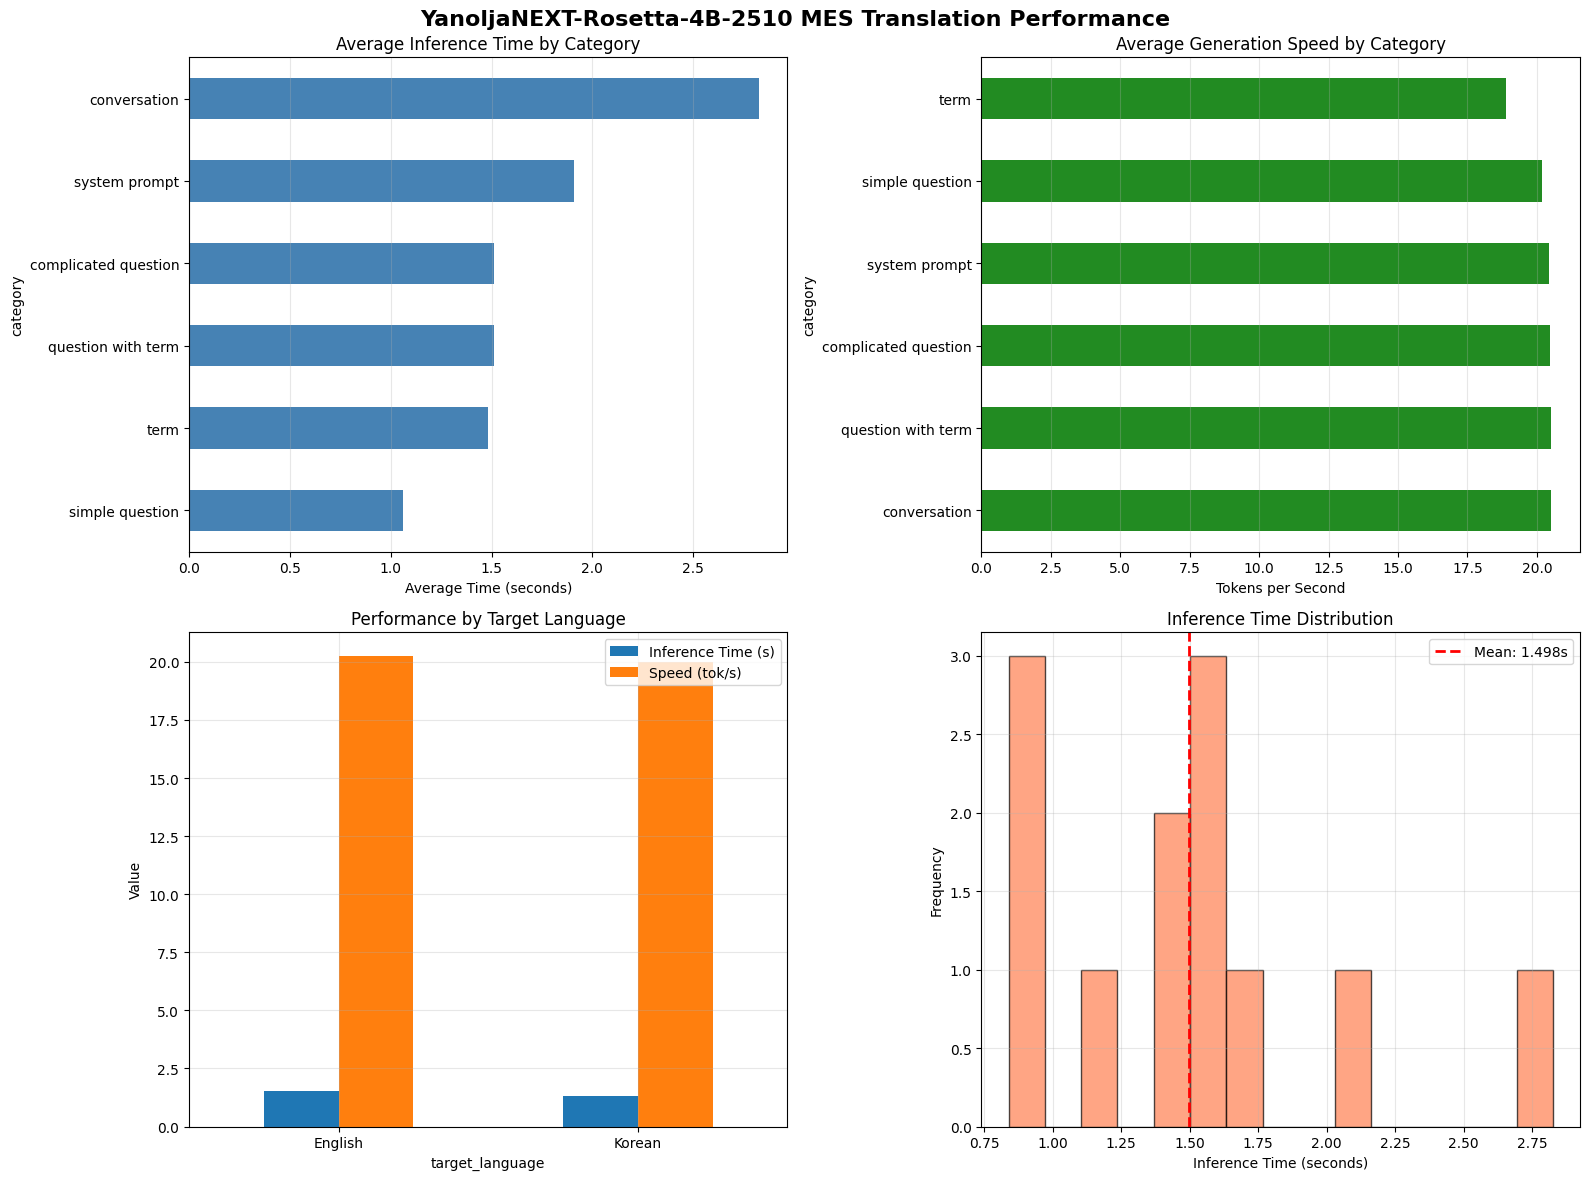

In [20]:
# 성능 시각화
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('YanoljaNEXT-Rosetta-4B-2510 MES Translation Performance', 
             fontsize=16, fontweight='bold')

# 1. 카테고리별 평균 추론 시간
category_time = df.groupby('category')['inference_time'].mean().sort_values()
category_time.plot(kind='barh', ax=axes[0, 0], color='steelblue')
axes[0, 0].set_xlabel('Average Time (seconds)')
axes[0, 0].set_title('Average Inference Time by Category')
axes[0, 0].grid(True, alpha=0.3, axis='x')

# 2. 카테고리별 평균 생성 속도
category_speed = df.groupby('category')['tokens_per_second'].mean().sort_values(ascending=False)
category_speed.plot(kind='barh', ax=axes[0, 1], color='forestgreen')
axes[0, 1].set_xlabel('Tokens per Second')
axes[0, 1].set_title('Average Generation Speed by Category')
axes[0, 1].grid(True, alpha=0.3, axis='x')

# 3. 타겟 언어별 비교
lang_stats = df.groupby('target_language')[['inference_time', 'tokens_per_second']].mean()
lang_stats.plot(kind='bar', ax=axes[1, 0], rot=0)
axes[1, 0].set_title('Performance by Target Language')
axes[1, 0].set_ylabel('Value')
axes[1, 0].legend(['Inference Time (s)', 'Speed (tok/s)'])
axes[1, 0].grid(True, alpha=0.3)

# 4. 추론 시간 분포
axes[1, 1].hist(df['inference_time'], bins=15, color='coral', edgecolor='black', alpha=0.7)
axes[1, 1].axvline(df['inference_time'].mean(), color='r', linestyle='--', 
                   linewidth=2, label=f'Mean: {df["inference_time"].mean():.3f}s')
axes[1, 1].set_xlabel('Inference Time (seconds)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Inference Time Distribution')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. 결과 저장

In [ ]:
# 결과를 CSV 파일로 저장
output_file = 'rosetta_mes_translation_results.csv'
df.to_csv(output_file, index=False, encoding='utf-8-sig')
print(f"✓ Results saved to: {output_file}")

# 요약 통계 저장
summary = {
    'model_name': MODEL_NAME,
    'total_samples': len(df),
    'categories': df['category'].unique().tolist(),
    'target_languages': df['target_language'].unique().tolist(),
    'avg_inference_time': float(df['inference_time'].mean()),
    'avg_tokens_per_second': float(df['tokens_per_second'].mean()),
    'device': device,
    'category_stats': {}
}

# 카테고리별 통계 추가
for category in df['category'].unique():
    cat_df = df[df['category'] == category]
    summary['category_stats'][category] = {
        'count': len(cat_df),
        'avg_time': float(cat_df['inference_time'].mean()),
        'avg_speed': float(cat_df['tokens_per_second'].mean())
    }

if torch.cuda.is_available():
    summary['gpu_name'] = torch.cuda.get_device_name(0)
    summary['avg_gpu_memory_mb'] = float(df['gpu_memory_used'].mean())

with open('rosetta_mes_translation_summary.json', 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)
    
print(f"✓ Summary saved to: rosetta_mes_translation_summary.json")

print("\n" + "=" * 80)
print("TEST COMPLETED SUCCESSFULLY!")
print("=" * 80)
print(f"\n총 {len(df)}개 샘플 테스트 완료")
print(f"평균 추론 시간: {df['inference_time'].mean():.3f}초")
print(f"평균 생성 속도: {df['tokens_per_second'].mean():.1f} tok/s")

## 12. 커스텀 MES 질문 테스트

In [ ]:
# 직접 테스트할 MES 질문/프롬프트 입력
print("=" * 80)
print("커스텀 MES 번역 테스트")
print("=" * 80)

# 예제 1: 간단한 질문
custom_source_1 = {
    "question1": "2025년 8월 생산에서 공정유형별 총 생산량, 양품, 불량 정보를 알려주세요.",
    "question2": "현재 작업중인 생산지시들의 목표수량 대비 실적수량 정보를 알려주세요.",
}
custom_context_1 = {
    "context": "User asking for production comparison",
    "tone": "Technical and analytical",
    "glossary": {
        "공정": "process"
    }
}

print("\n[예제 1] 간단한 질문 (한국어 → 영어)")
print("-" * 80)
print("Source:")
print(json.dumps(custom_source_1, indent=2, ensure_ascii=False))

result1 = translate_rosetta(custom_source_1, "English", context=custom_context_1)
print("\nTranslation:")
print(json.dumps(result1['translation'], indent=2, ensure_ascii=False))
print(f"\n⏱️ {result1['inference_time']:.3f}s | 🚀 {result1['tokens_per_second']:.1f} tok/s")

# 예제 2
# custom_source_2 = {
#     "request": "MTTR과 MTBF 지표를 분석하고 개선 방안을 제시해주세요."
# }
# custom_context_2 = {
#     "context": "Maintenance metrics analysis request",
#     "tone": "Technical and analytical",
#     "glossary": {
#         "MTTR": "Mean Time To Repair",
#         "MTBF": "Mean Time Between Failures"
#     }
# }

# print("\n" + "=" * 80)
# print("[예제 2] 용어집 포함 질문 (한국어 → 영어)")
# print("-" * 80)
# print("Source:")
# print(json.dumps(custom_source_2, indent=2, ensure_ascii=False))
# print("\nContext:")
# print(json.dumps(custom_context_2, indent=2, ensure_ascii=False))

# result2 = translate_rosetta(custom_source_2, "English", context=custom_context_2)
# print("\nTranslation:")
# print(json.dumps(result2['translation'], indent=2, ensure_ascii=False))
# print(f"\n⏱️ {result2['inference_time']:.3f}s | 🚀 {result2['tokens_per_second']:.1f} tok/s")

# # 예제 3: 영어 → 한국어
# custom_source_3 = {
#     "question": "What were the top 3 causes of downtime last month?"
# }
# custom_context_3 = {
#     "context": "Analyzing downtime causes",
#     "tone": "Natural and informative"
# }

# print("\n" + "=" * 80)
# print("[예제 3] 영어 → 한국어")
# print("-" * 80)
# print("Source:")
# print(json.dumps(custom_source_3, indent=2, ensure_ascii=False))

# result3 = translate_rosetta(custom_source_3, "Korean", context=custom_context_3)
# print("\nTranslation:")
# print(json.dumps(result3['translation'], indent=2, ensure_ascii=False))
# print(f"\n⏱️ {result3['inference_time']:.3f}s | 🚀 {result3['tokens_per_second']:.1f} tok/s")

커스텀 MES 번역 테스트

[예제 1] 간단한 질문 (한국어 → 영어)
--------------------------------------------------------------------------------
Source:
{
  "question1": "2025년 8월 생산에서 공정유형별 총 생산량, 양품, 불량 정보를 알려주세요.",
  "question2": "현재 작업중인 생산지시들의 목표수량 대비 실적수량 정보를 알려주세요."
}

Translation:
{
  "question1": "Please provide information on the total production volume, yield, and defect rates by process type for August 2025 production.",
  "question2": "Please provide information on the actual production quantity compared to the target quantity for the production orders currently in progress."
}

⏱️ 3.034s | 🚀 19.4 tok/s
